In [4]:
import torch
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from kan import KAN, LBFGS

device = torch.device("cuda:0")
print("Using device:", device)

rho = torch.tensor(1.0, device=device)
nu = torch.tensor(0.01, device=device)
eps = torch.tensor(1e-8, device=device)

width, height = 10.0, 2.0
num_points_x, num_points_y = 100, 20

x = torch.linspace(0, width, num_points_x, device=device)
y = torch.linspace(0, height, num_points_y, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')
coordinates = torch.stack([X.flatten(), Y.flatten()], dim=1)

model = KAN(width=[2,3,3, 3], grid=5, k=10, grid_eps=1.0,
            noise_scale_base=0., device=torch.device('cuda:0')).to(device)


def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)


def navier_stokes_residuals(coords):
    y_pred = model(coords)
    grads = batch_jacobian(model, coords)

    u, v, p = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    u_x, u_y = grads[:, 0, 0], grads[:, 0, 1]
    v_x, v_y = grads[:, 1, 0], grads[:, 1, 1]
    p_x, p_y = grads[:, 2, 0], grads[:, 2, 1]

    continuity = u_x + v_y + eps * p # Assuming incompressibility (no source/sink terms)
    x_momentum = u * u_x + v * u_y + (1 / rho) * p_x - nu * (u_x + u_y)
    y_momentum = u * v_x + v * v_y + (1 / rho) * p_y - nu * (v_x + v_y)

    #coords are a Nx2 tensor where each row is [x, y]
    no_slip_mask = (coords[:, 1] == 0) | (coords[:, 1] == height)  # No-slip at top and bottom
    inlet_mask = (coords[:, 0] == 0)  # Inlet at x = 0
    outlet_mask = (coords[:, 0] == width)  # Outlet at x = width

    # Applying boundary conditions
    no_slip_loss = torch.mean(u[no_slip_mask] ** 2 + v[no_slip_mask] ** 2)  # u and v should be zero
    inlet_loss = torch.mean((u[inlet_mask] - 1) ** 2)  # u should be 1, v should be 0 at inlet
    outlet_pressure_loss = torch.mean(p[outlet_mask] ** 2)  # p should be 0 at outlet

    # Combine all losses
    bc_loss = no_slip_loss + inlet_loss + outlet_pressure_loss
    total_loss = torch.mean(continuity ** 2 + x_momentum ** 2 + y_momentum ** 2) + bc_loss
    return total_loss



writer = SummaryWriter()


def train():
    optimizer = LBFGS(model.parameters(), lr=1,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    steps = 20
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = navier_stokes_residuals(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 5 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.3f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)


train()

writer.close()


Using device: cuda:0


Step: 15 | Loss: 0.179: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


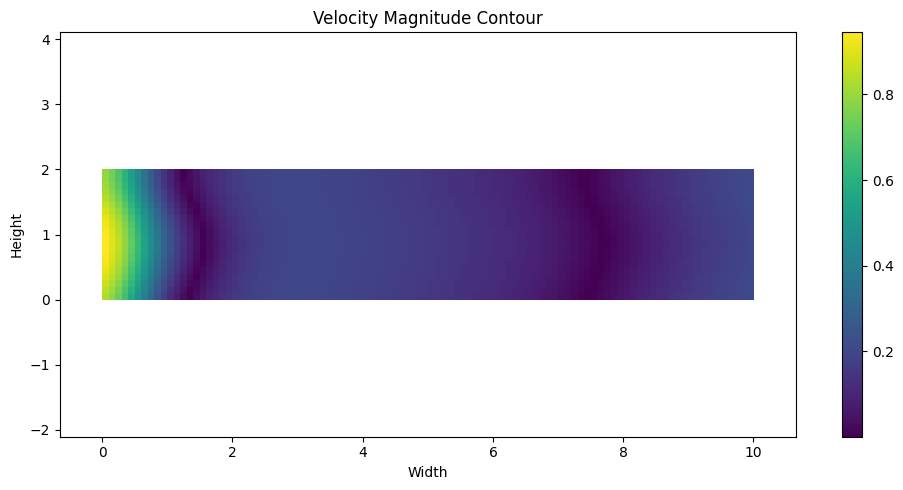

In [7]:
u_pred = model(coordinates)[:, 0].detach().reshape(
    num_points_x, num_points_y).T.cpu()

v_pred = model(coordinates)[:, 1].detach().reshape(
    num_points_x, num_points_y).T.cpu()


magnitude = torch.sqrt(u_pred ** 2 + v_pred ** 2)

plt.figure(figsize=(10, 5))  # Set the figure size as needed
plt.imshow(magnitude, extent=(0, width, 0, height), origin='lower', cmap='viridis')
plt.colorbar()  # Add a colorbar to show the magnitude scale
plt.title('Velocity Magnitude Contour')
plt.xlabel('Width')
plt.ylabel('Height')
plt.axis('equal')  # Ensure the plot has equal scaling
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

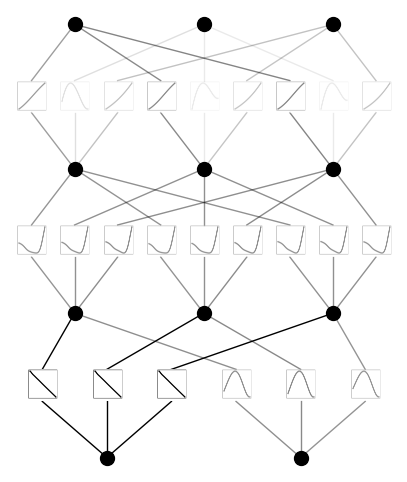

In [6]:
model.plot(beta=10)